<a href="https://colab.research.google.com/github/JerameyATyler/colab/blob/master/mfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JerameyATyler/colab/blob/master/mfcc.ipynb)

# Convolutional Neural Networks for Mandarin Tone Classification using Mel-Frequency Cepstral Coefficients

Jeramey Tyler tylerj2@rpi.edu


---



# Introduction

In a tonal language, semantic information is conveyed through the pronunication of the a spoken word. This adds an dimension of complexity to automatic speech recognition tasks (ASR) involving tonal languages. In this notebook I demonstrate classifying Mandarin tones using a convolutional neural network trained on the Mel-frequency cepstral coefficients (MFCC) representation of spoken Mandarin phonemes.

# Data

## Data Loading

The data for this experiment is stored at [this](https://github.com/JerameyATyler/Mandarin_data) GitHub repository. The code below will clone the repository.

In [1]:
!git clone https://github.com/JerameyATyler/Mandarin_data.git

Cloning into 'Mandarin_data'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


Read data into a Pandas Dataframe.

In [2]:
import pandas as pd

def load_data():
  df = pd.read_pickle('Mandarin_data/mfcc_small.pkl', compression=None)
  
  return df

df = load_data()
df.head(3)

,mfcc,Tone
0,"[[-310.8796789564301, -340.46618065634357, -35...",2.0
1,"[[-266.5372726841016, -259.1848098190291, -264...",1.0
2,"[[-291.45163988780587, -251.88196659859761, -2...",3.0


## Data Representation

Let's see what our data looks like.

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def data_peek(x_):
  print('The shape is:', x_.shape)
  print('An element looks like:\n', x_[0])
  
def plot_mfcc(mfcc):
  fig, ax = plt.subplots()
  cax = ax.imshow(mfcc, interpolation='nearest', cmap=cm.coolwarm,
                 origin='lower')
  ax.set_title('MFCC')
  plt.show()

data_peek(df[['mfcc']].values)

The shape is: (16026, 1)
An element looks like:
 [array([[-3.10879679e+02, -3.40466181e+02, -3.57547799e+02,
        -3.37239442e+02],
       [ 1.47140835e+02,  1.44148258e+02,  1.57003995e+02,
         1.64028318e+02],
       [ 6.54336107e+00, -8.34052299e-01, -1.16083192e+01,
        -1.28333806e+01],
       [ 6.34890104e+01,  6.54637822e+01,  6.88406324e+01,
         7.06317975e+01],
       [ 1.78298126e+01,  1.67627488e+01,  2.54703132e+01,
         3.28208402e+01],
       [-1.07758198e+00, -4.72788243e+00, -1.94982063e+01,
        -2.90835285e+01],
       [ 1.22708489e+01,  1.74007855e+01,  1.66135280e+01,
         1.45633625e+01],
       [-2.25837740e+01, -1.91953050e+01, -7.87243110e+00,
        -1.45858052e+00],
       [-2.23698884e+01, -2.17985852e+01, -2.21270462e+01,
        -1.92849987e+01],
       [-1.01292864e+01, -1.21503618e+01, -2.43503587e+01,
        -2.43666225e+01],
       [-1.39319800e+01, -8.81153077e+00, -6.88731804e-01,
        -1.11509983e+00],
       [-1.8796

In [7]:
data_peek(df[['Tone']].values)

The shape is: (16026, 1)
An element looks like:
 [2.]


Let's visualize our data.

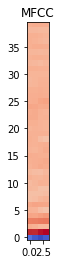

In [8]:
plot_mfcc(df['mfcc'].iloc[0])

# Pre-processing

In [33]:
from keras.utils import to_categorical

def preprocess():
  # Load the data into memory
  df = load_data()
  df['mfcc'] = df['mfcc'].apply(lambda i: i.reshape(40, -1))
  
  ''' Convert tone categorization to a one-hot categorization '''
  # Subtract 1 so that classification aligns with index
  df['Tone'] = df['Tone'].apply(lambda i: int(i - 1))
  # 
  df['Tone'] = df['Tone'].apply(lambda i: to_categorical(i, num_classes=4))
  
  return df

df = preprocess()
data_peek(df[['mfcc']].values)  

The shape is: (16026, 1)
An element looks like:
 [array([[-3.10879679e+02, -3.40466181e+02, -3.57547799e+02,
        -3.37239442e+02],
       [ 1.47140835e+02,  1.44148258e+02,  1.57003995e+02,
         1.64028318e+02],
       [ 6.54336107e+00, -8.34052299e-01, -1.16083192e+01,
        -1.28333806e+01],
       [ 6.34890104e+01,  6.54637822e+01,  6.88406324e+01,
         7.06317975e+01],
       [ 1.78298126e+01,  1.67627488e+01,  2.54703132e+01,
         3.28208402e+01],
       [-1.07758198e+00, -4.72788243e+00, -1.94982063e+01,
        -2.90835285e+01],
       [ 1.22708489e+01,  1.74007855e+01,  1.66135280e+01,
         1.45633625e+01],
       [-2.25837740e+01, -1.91953050e+01, -7.87243110e+00,
        -1.45858052e+00],
       [-2.23698884e+01, -2.17985852e+01, -2.21270462e+01,
        -1.92849987e+01],
       [-1.01292864e+01, -1.21503618e+01, -2.43503587e+01,
        -2.43666225e+01],
       [-1.39319800e+01, -8.81153077e+00, -6.88731804e-01,
        -1.11509983e+00],
       [-1.8796

Let's fetch our values

In [47]:
def fetch_xy(df):
  x = np.array(np.array(df[['mfcc']].values))
  y = np.array([np.array(i[0]).reshape(4) for i in df[['Tone']].values])
  
  return x, y

x, y = fetch_xy(df)
data_peek(x)
data_peek(y)

The shape is: (16026, 1)
An element looks like:
 [array([[-3.10879679e+02, -3.40466181e+02, -3.57547799e+02,
        -3.37239442e+02],
       [ 1.47140835e+02,  1.44148258e+02,  1.57003995e+02,
         1.64028318e+02],
       [ 6.54336107e+00, -8.34052299e-01, -1.16083192e+01,
        -1.28333806e+01],
       [ 6.34890104e+01,  6.54637822e+01,  6.88406324e+01,
         7.06317975e+01],
       [ 1.78298126e+01,  1.67627488e+01,  2.54703132e+01,
         3.28208402e+01],
       [-1.07758198e+00, -4.72788243e+00, -1.94982063e+01,
        -2.90835285e+01],
       [ 1.22708489e+01,  1.74007855e+01,  1.66135280e+01,
         1.45633625e+01],
       [-2.25837740e+01, -1.91953050e+01, -7.87243110e+00,
        -1.45858052e+00],
       [-2.23698884e+01, -2.17985852e+01, -2.21270462e+01,
        -1.92849987e+01],
       [-1.01292864e+01, -1.21503618e+01, -2.43503587e+01,
        -2.43666225e+01],
       [-1.39319800e+01, -8.81153077e+00, -6.88731804e-01,
        -1.11509983e+00],
       [-1.8796

We need to reshape the MFCC 

In [48]:
x = [i[0].reshape(1, 40, -1) for i in x]

min_size = min([i.shape for i in x])
max_size = max([i.shape for i in x])
print('Min sample size:', min_size)
print('Max sample size:', max_size)

Min sample size: (1, 40, 2)
Max sample size: (1, 40, 30)


We need the lengths of each MFCC to be the same. This function will pad each until they are all the same size as the largest sample in the dataset.

In [49]:
def pad_mfcc(x_, size):
  result = np.zeros(size)
  result[:x_.shape[0],:x_.shape[1], :x_.shape[2]] = x_
  return result

x = [pad_mfcc(i, max_size) for i in x]
x = np.array(x)

data_peek(x)

The shape is: (16026, 1, 40, 30)
An element looks like:
 [[[-310.87967896 -340.46618066 -357.54779874 ...    0.
      0.            0.        ]
  [ 147.14083516  144.14825793  157.00399538 ...    0.
      0.            0.        ]
  [   6.54336107   -0.8340523   -11.60831919 ...    0.
      0.            0.        ]
  ...
  [   2.57727378    1.53993865   -2.8129425  ...    0.
      0.            0.        ]
  [ -10.63788455   -9.2113148   -11.20401621 ...    0.
      0.            0.        ]
  [   2.3438357     5.12753642    6.55445454 ...    0.
      0.            0.        ]]]


Now let's pre-process our labels. 

In [50]:
data_peek(y)

The shape is: (16026, 4)
An element looks like:
 [0. 1. 0. 0.]


In [51]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, 
                                                random_state=502)
data_peek(xTrain)
data_peek(yTrain)

The shape is: (12820, 1, 40, 30)
An element looks like:
 [[[-310.7386427  -284.72220936 -299.21057504 ...    0.
      0.            0.        ]
  [ 152.35789553  171.2332157   180.4695477  ...    0.
      0.            0.        ]
  [ -39.45548486  -45.54806333  -43.26040024 ...    0.
      0.            0.        ]
  ...
  [   2.53544713    2.24401134    0.52120567 ...    0.
      0.            0.        ]
  [  -4.04034943   -2.47248425    1.07673535 ...    0.
      0.            0.        ]
  [   3.61585894    3.44456431    4.03078513 ...    0.
      0.            0.        ]]]
The shape is: (12820, 4)
An element looks like:
 [0. 0. 0. 1.]


In [52]:
from sklearn import preprocessing

X_train = np.array([preprocessing.scale(i.reshape(40, 30)) for i in xTrain])
X_test = np.array([preprocessing.scale(i.reshape(40, 30)) for i in xTest])
data_peek(X_train)

The shape is: (12820, 40, 30)
An element looks like:
 [[-5.54647868e+00 -5.28417261e+00 -5.27644384e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.82761362e+00  3.26261063e+00  3.25772187e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.40913606e-01 -8.00906329e-01 -7.22740026e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 1.18400945e-01  9.49455017e-02  5.61946481e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.08013888e-04  6.53583878e-03  6.60782812e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.37937840e-01  1.17449601e-01  1.18634869e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [0]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adadelta
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.regularizers import l1, l2
import matplotlib.pyplot as plt

In [0]:
def plot_model(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 40, 30..., data_format="channels_first")`
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 10256 samples, validate on 2564 samples
Epoch 1/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.5982 - acc: 0.3425 - val_loss: 1.2554 - val_acc: 0.4696
Epoch 2/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.2655 - acc: 0.4430 - val_loss: 1.2346 - val_acc: 0.4524
Epoch 3/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.2137 - acc: 0.4807 - val_loss: 1.1514 - val_acc: 0.5246
Epoch 4/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.1768 - acc: 0.5077 - val_loss: 1.1370 - val_acc: 0.5250
Epoch 5/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.1428 - acc: 0.5288 - val_loss: 1.1254 - val_acc: 0.5558
Epoch 6/100
10256/10256 [==============================] - 20s 2ms/step - loss: 1.1195 - acc: 0.54

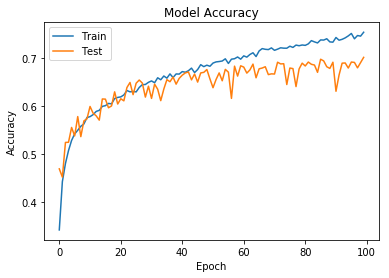

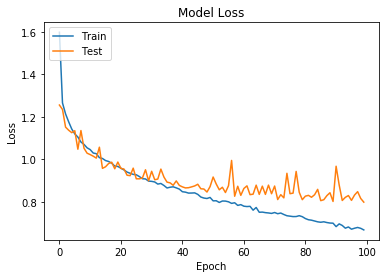

In [55]:
def cnn(x_train, x_test, y_train, y_test):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], dim_ordering='th'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.125))
  
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.125))
  
  model.add(Flatten())
  model.add(Dense(128, activation='relu',
                   kernel_regularizer=l2(0.00001),
                   activity_regularizer=l1(0.00001)))
  model.add(Dropout(0.125))
  model.add(Dense(4, activation='softmax'))
  
  optimizer = SGD(lr=0.01, momentum=1e-2, decay=1e-6)
  # optimizer = RMSprop(lr=0.00001, decay=1e-8)
  # optimizer = Adadelta()

  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

  model_history = model.fit(x_train, y_train,
           epochs=100,
         batch_size=128, verbose=1, validation_split=0.2)
  score = model.evaluate(x_test, y_test, batch_size=32)
  print('Model accuracy is:', score[1])

  plot_model(model_history)
  return model_history
 
cnn(xTrain, xTest, yTrain, yTest)